In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [ ]:
# Device configurations
device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters
G_Embed = 100
Z_DIM = 100
Epochs = 5
Batch_Size = 64
Feat_Critic = 16
Feat_G = 16
Critic_Iterations = 5
L_GP = 10
LR = 1e-5
IMG_SIZE = 64
CHANNELS_IMG = 1
NUM_CLASSES = 10

In [ ]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

In [ ]:

dataset = datasets.FashionMNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(
    dataset,
    batch_size=Batch_Size,
    shuffle=True,
)
#Loading the FashionMNIST dataset

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x,labels):
        return self.disc(x)


In [ ]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g, num_classes, img_size, embed_size):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(channels_noise, features_g * 8, 4, 1, 0),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            self._block(features_g * 2, features_g, 4, 2, 1),
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x,labels):
        return self.net(x)


In [ ]:
# Weight Initialization and Testing
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "D-test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "G-test failed"

In [ ]:
# Gradient Penalty for stabalising th GAN while training
def gradient_penalty(critic, real, labels, fake, device="cpu"):
    Batch_Size, C, H, W = real.shape
    alpha = torch.rand((Batch_Size, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, labels)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [ ]:
# Saving and loading of checkpoints
def save_checkpoint(state, filename="celeba_wgan_gp.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, gen, disc):
    print("=> Loading checkpoint")
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])

In [ ]:
# Initialize gen and disc
gen = Generator(Z_DIM, CHANNELS_IMG, Feat_G, NUM_CLASSES, IMG_SIZE, G_Embed).to(device)
critic = Discriminator(CHANNELS_IMG, Feat_Critic, NUM_CLASSES, IMG_SIZE).to(device)
initialize_weights(gen)
initialize_weights(critic)

# Initialize optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LR, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LR, betas=(0.0, 0.9))

In [ ]:
# For tensorboard plotting
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/GAN_MNIST/real")
writer_fake = SummaryWriter(f"logs/GAN_MNIST/fake")
step = 0

# Setting the generator to training mode
gen.train()
critic.train()

for epoch in range(Epochs):
    for batch_idx, (real, labels) in enumerate(tqdm(loader)):
        real = real.to(device)
        cur_batch_size = real.shape[0]
        labels = labels.to(device)
        for _ in range(Critic_Iterations):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise, labels)
            critic_real = critic(real, labels).reshape(-1)
            critic_fake = critic(fake, labels).reshape(-1)
            gp = gradient_penalty(critic, real, labels, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + L_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator
        gen_fake = critic(fake, labels).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        # Tensorboard is used for visualising the fake images by the model
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{Epochs}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(noise, labels)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

 11%|█         | 100/938 [00:14<01:41,  8.26it/s]

Epoch [0/5] Batch 100/938                   Loss D: 2.2839, loss G: 0.0842


 21%|██▏       | 201/938 [00:27<01:54,  6.46it/s]

Epoch [0/5] Batch 200/938                   Loss D: -0.7336, loss G: 0.4740


 32%|███▏      | 301/938 [00:40<01:38,  6.48it/s]

Epoch [0/5] Batch 300/938                   Loss D: -1.5908, loss G: 0.9078


 43%|████▎     | 401/938 [00:53<01:22,  6.53it/s]

Epoch [0/5] Batch 400/938                   Loss D: -2.6425, loss G: 1.3561


 53%|█████▎    | 501/938 [01:06<01:11,  6.15it/s]

Epoch [0/5] Batch 500/938                   Loss D: -3.6754, loss G: 1.8862


 64%|██████▍   | 601/938 [01:18<00:52,  6.44it/s]

Epoch [0/5] Batch 600/938                   Loss D: -4.8810, loss G: 2.5021


 75%|███████▍  | 701/938 [01:31<00:36,  6.49it/s]

Epoch [0/5] Batch 700/938                   Loss D: -6.6435, loss G: 3.2078


 85%|████████▌ | 801/938 [01:44<00:21,  6.48it/s]

Epoch [0/5] Batch 800/938                   Loss D: -8.2858, loss G: 4.0036


 96%|█████████▌| 901/938 [01:57<00:05,  6.44it/s]

Epoch [0/5] Batch 900/938                   Loss D: -10.2004, loss G: 4.8887


 11%|█         | 101/938 [00:12<02:10,  6.41it/s]

Epoch [1/5] Batch 100/938                   Loss D: -13.1339, loss G: 6.2602


 21%|██▏       | 201/938 [00:25<01:56,  6.33it/s]

Epoch [1/5] Batch 200/938                   Loss D: -15.4793, loss G: 7.3592


 32%|███▏      | 301/938 [00:38<01:43,  6.15it/s]

Epoch [1/5] Batch 300/938                   Loss D: -18.0295, loss G: 8.5463


 43%|████▎     | 401/938 [00:51<01:24,  6.35it/s]

Epoch [1/5] Batch 400/938                   Loss D: -20.7535, loss G: 9.8230


 53%|█████▎    | 501/938 [01:04<01:09,  6.25it/s]

Epoch [1/5] Batch 500/938                   Loss D: -23.7154, loss G: 11.1892


 64%|██████▍   | 601/938 [01:17<00:52,  6.48it/s]

Epoch [1/5] Batch 600/938                   Loss D: -26.8063, loss G: 12.6437


 75%|███████▍  | 701/938 [01:30<00:37,  6.29it/s]

Epoch [1/5] Batch 700/938                   Loss D: -30.1298, loss G: 14.1860


 85%|████████▌ | 801/938 [01:43<00:21,  6.26it/s]

Epoch [1/5] Batch 800/938                   Loss D: -33.6493, loss G: 15.8157


 96%|█████████▌| 901/938 [01:56<00:06,  6.16it/s]

Epoch [1/5] Batch 900/938                   Loss D: -37.3710, loss G: 17.5323


 11%|█         | 101/938 [00:13<02:12,  6.32it/s]

Epoch [2/5] Batch 100/938                   Loss D: -42.7862, loss G: 20.0405


 21%|██▏       | 201/938 [00:26<01:57,  6.27it/s]

Epoch [2/5] Batch 200/938                   Loss D: -46.9803, loss G: 21.9624


 32%|███▏      | 301/938 [00:39<01:38,  6.48it/s]

Epoch [2/5] Batch 300/938                   Loss D: -51.3287, loss G: 23.9706


 43%|████▎     | 401/938 [00:52<01:24,  6.33it/s]

Epoch [2/5] Batch 400/938                   Loss D: -55.8935, loss G: 26.0656


 53%|█████▎    | 501/938 [01:05<01:10,  6.17it/s]

Epoch [2/5] Batch 500/938                   Loss D: -60.6590, loss G: 28.2478


 64%|██████▍   | 601/938 [01:18<00:53,  6.29it/s]

Epoch [2/5] Batch 600/938                   Loss D: -65.5974, loss G: 30.5161


 75%|███████▍  | 701/938 [01:31<00:36,  6.41it/s]

Epoch [2/5] Batch 700/938                   Loss D: -70.7253, loss G: 32.8708


 85%|████████▌ | 801/938 [01:44<00:21,  6.32it/s]

Epoch [2/5] Batch 800/938                   Loss D: -76.0600, loss G: 35.3137


 96%|█████████▌| 901/938 [01:57<00:05,  6.27it/s]

Epoch [2/5] Batch 900/938                   Loss D: -81.5949, loss G: 37.8420


 11%|█         | 101/938 [00:13<02:16,  6.13it/s]

Epoch [3/5] Batch 100/938                   Loss D: -89.5497, loss G: 41.4770


 21%|██▏       | 201/938 [00:25<01:56,  6.35it/s]

Epoch [3/5] Batch 200/938                   Loss D: -95.5242, loss G: 44.2191


 32%|███▏      | 301/938 [00:38<01:42,  6.19it/s]

Epoch [3/5] Batch 300/938                   Loss D: -101.6965, loss G: 47.0474


 43%|████▎     | 401/938 [00:51<01:24,  6.36it/s]

Epoch [3/5] Batch 400/938                   Loss D: -108.0712, loss G: 49.9635


 53%|█████▎    | 501/938 [01:04<01:08,  6.37it/s]

Epoch [3/5] Batch 500/938                   Loss D: -114.6401, loss G: 52.9661


 64%|██████▍   | 601/938 [01:17<00:52,  6.40it/s]

Epoch [3/5] Batch 600/938                   Loss D: -121.4046, loss G: 56.0542


 75%|███████▍  | 701/938 [01:30<00:37,  6.35it/s]

Epoch [3/5] Batch 700/938                   Loss D: -128.3237, loss G: 59.2319


 85%|████████▌ | 801/938 [01:43<00:21,  6.32it/s]

Epoch [3/5] Batch 800/938                   Loss D: -135.4872, loss G: 62.4956


 96%|█████████▌| 901/938 [01:56<00:05,  6.28it/s]

Epoch [3/5] Batch 900/938                   Loss D: -142.8614, loss G: 65.8453


 11%|█         | 101/938 [00:12<02:09,  6.47it/s]

Epoch [4/5] Batch 100/938                   Loss D: -153.2975, loss G: 70.6082


 21%|██▏       | 201/938 [00:25<01:55,  6.40it/s]

Epoch [4/5] Batch 200/938                   Loss D: -161.1017, loss G: 74.1650


 32%|███▏      | 301/938 [00:38<01:39,  6.40it/s]

Epoch [4/5] Batch 300/938                   Loss D: -169.0509, loss G: 77.8121


 43%|████▎     | 401/938 [00:51<01:23,  6.46it/s]

Epoch [4/5] Batch 400/938                   Loss D: -177.2522, loss G: 81.5423


 53%|█████▎    | 501/938 [01:04<01:07,  6.46it/s]

Epoch [4/5] Batch 500/938                   Loss D: -185.6828, loss G: 85.3620


 64%|██████▍   | 601/938 [01:17<00:51,  6.50it/s]

Epoch [4/5] Batch 600/938                   Loss D: -194.2523, loss G: 89.2689


 75%|███████▍  | 701/938 [01:30<00:36,  6.54it/s]

Epoch [4/5] Batch 700/938                   Loss D: -203.0539, loss G: 93.2559


 85%|████████▌ | 801/938 [01:43<00:21,  6.42it/s]

Epoch [4/5] Batch 800/938                   Loss D: -212.0180, loss G: 97.3384


 96%|█████████▌| 901/938 [01:55<00:05,  6.52it/s]

Epoch [4/5] Batch 900/938                   Loss D: -221.1571, loss G: 101.4968


100%|██████████| 938/938 [02:01<00:00,  7.75it/s]


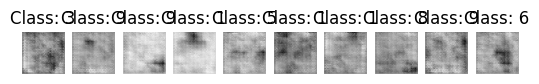

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the Generator to evaluation mode
gen.eval()

# Select a few random labels for conditional generation
num_samples = 10
random_labels = torch.randint(0, NUM_CLASSES, (num_samples,), device=device)

# Generate samples for each label
with torch.no_grad():
    fixed_noise = torch.randn(num_samples, Z_DIM, 1, 1).to(device)
    generated_samples = gen.forward(fixed_noise, random_labels).to(device)

# Visualize the generated samples
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(generated_samples[i][0].cpu().numpy(), cmap='gray')
    plt.title(f'Class: {random_labels[i].item()}')

    plt.axis('off')

plt.show()

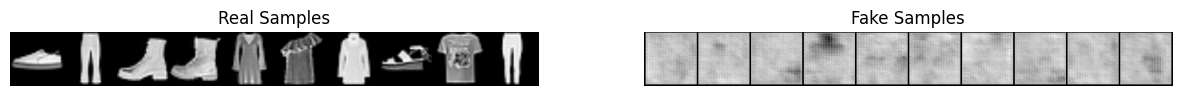

In [ ]:
# Set the Generator and Discriminator to evaluation mode
gen.eval()
critic.eval()

# Generate fake samples for visual analysis
with torch.no_grad():
    fake_samples = gen(fixed_noise, random_labels)

# Visualize real and fake samples side by side
real_batch, _ = next(iter(loader))
real_samples = real_batch[:num_samples].to(device)

plt.figure(figsize=(15, 5))

# Visualize Real Samples
plt.subplot(1, 2, 1)
plt.imshow(torchvision.utils.make_grid(real_samples, nrow=num_samples, normalize=True).cpu().numpy().transpose(1, 2, 0))
plt.title('Real Samples')
plt.axis('off')

# Visualize Fake Samples
plt.subplot(1, 2, 2)
plt.imshow(torchvision.utils.make_grid(fake_samples, nrow=num_samples, normalize=True).cpu().numpy().transpose(1, 2, 0))
plt.title('Fake Samples')
plt.axis('off')

plt.show()